<a href="https://colab.research.google.com/github/manishmawatwal/DataScience/blob/main/Predicting_trajectories_of_atlantic_hurricanes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install geopandas

In [2]:
#upload the file
from google.colab import files
uploaded=files.upload()

Saving atlantic.csv to atlantic (2).csv


In [3]:
#import the required libraries
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-dark')
import warnings
import copy
warnings.simplefilter('ignore')
plt.style.use('bmh')
import folium
from folium.plugins import HeatMap

In [4]:
#read the file
df = pd.read_csv('atlantic.csv')
df.head(5)

,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,Low Wind NE,Low Wind SE,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW
0,AL011851,UNNAMED,18510625,0,,HU,28.0N,94.8W,80,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
1,AL011851,UNNAMED,18510625,600,,HU,28.0N,95.4W,80,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
2,AL011851,UNNAMED,18510625,1200,,HU,28.0N,96.0W,80,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
3,AL011851,UNNAMED,18510625,1800,,HU,28.1N,96.5W,80,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
4,AL011851,UNNAMED,18510625,2100,L,HU,28.2N,96.8W,80,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999


In [5]:
df.shape

(49105, 22)

In [6]:
df.columns

Index(['ID', 'Name', 'Date', 'Time', 'Event', 'Status', 'Latitude',
       'Longitude', 'Maximum Wind', 'Minimum Pressure', 'Low Wind NE',
       'Low Wind SE', 'Low Wind SW', 'Low Wind NW', 'Moderate Wind NE',
       'Moderate Wind SE', 'Moderate Wind SW', 'Moderate Wind NW',
       'High Wind NE', 'High Wind SE', 'High Wind SW', 'High Wind NW'],
      dtype='object')

In [7]:
df.Status.unique()

array([' HU', ' TS', ' EX', ' TD', ' LO', ' DB', ' SD', ' SS', ' WV'],
      dtype=object)

 TS    17804
 HU    14537
 TD     9891
 EX     4798
 LO     1005
 SS      557
 SD      293
 WV      116
 DB      104
Name: Status, dtype: int64


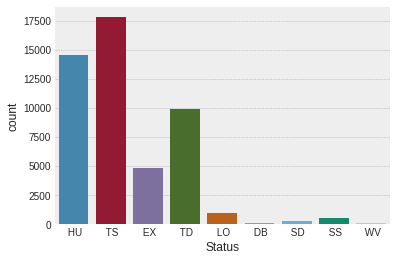

In [8]:
sns.countplot(x='Status', data=df)
print(df.Status.value_counts())

In [9]:
df.Event.unique()

array(['  ', ' L', ' R', ' I', ' P', ' W', ' C', ' S', ' G', ' T'],
      dtype=object)

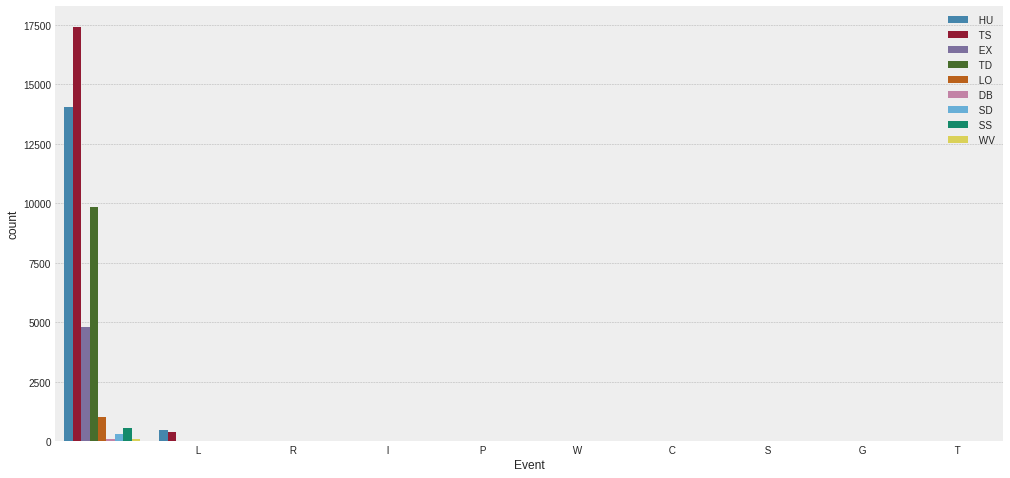

In [10]:
plt.figure(figsize=(17,8))
sns.countplot(df.Event, hue=df.Status)
plt.legend(loc='upper right')

In [11]:
df.Time.unique()

array([   0,  600, 1200, 1800, 2100, 1500, 2000,  300, 1100, 1000, 1700,
       1600,  400,  800,  900, 1300, 1400,  700, 2200, 1900, 2300,  200,
        500,  100, 1930, 1630, 1830, 1530,   30, 1330, 1725,  530, 2230,
       1145, 2046, 1720,  130,  834,  840,  905,  830, 2130,  615, 2152,
       1730,  330,  930,  430, 1230, 1130,  630,  756, 1105,  915,   45,
       2013, 1030, 1945, 2045,  730, 1415,  650, 2235,  245, 1845, 1110,
       1445,  740, 2145,  645, 1115,  340,  845, 1315, 1745, 1820, 1430,
       2030, 2315,  515, 1245, 1645,  230,  525,  935,  410,  315, 1615,
       2330,  445,  810, 2245])

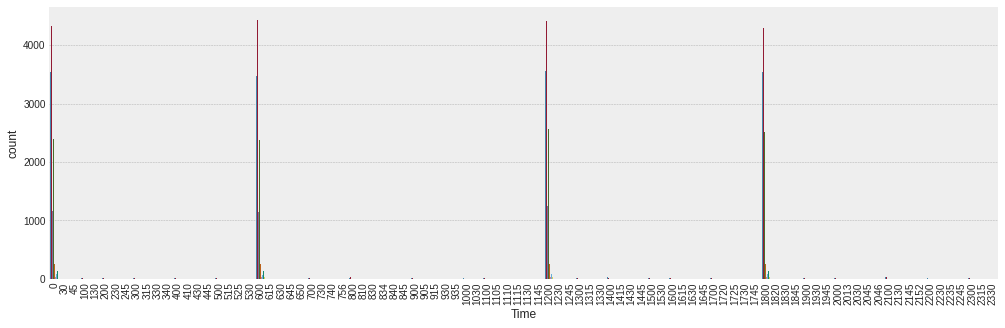

In [12]:
plt.figure(figsize=(17,5))
sns.countplot(df.Time, hue=df.Status)
plt.legend('')
plt.xticks(rotation=90)
plt.show()

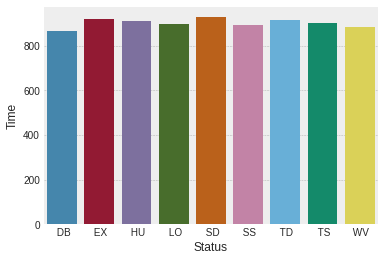

In [13]:
a = df.groupby(by='Status')['Time'].mean()
sns.barplot(x=a.index, y=a)

<Figure size 432x288 with 0 Axes>

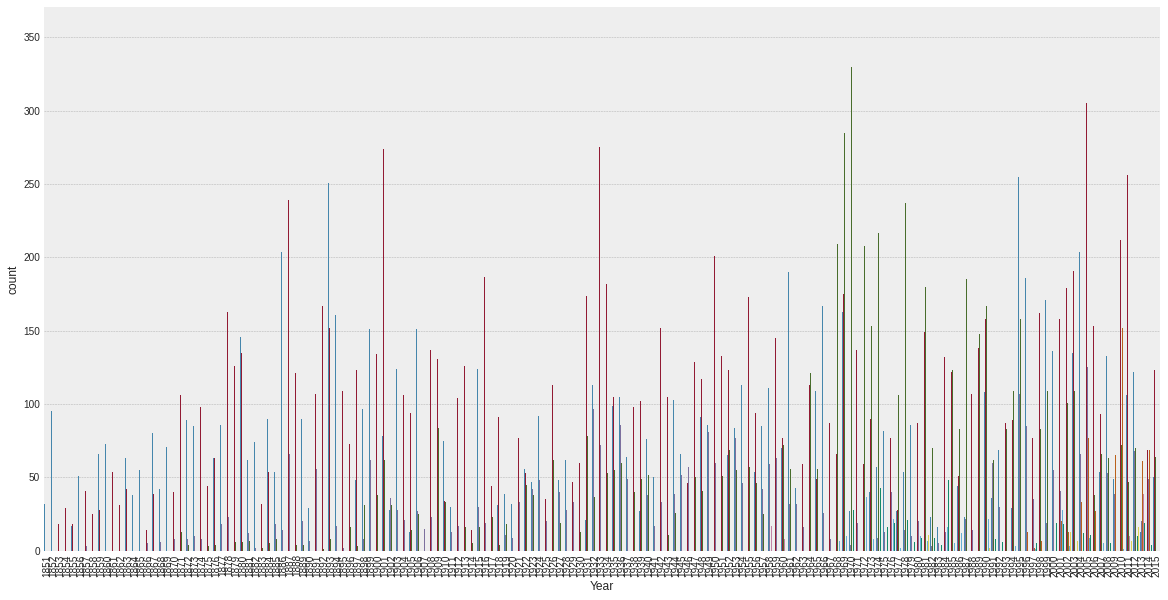

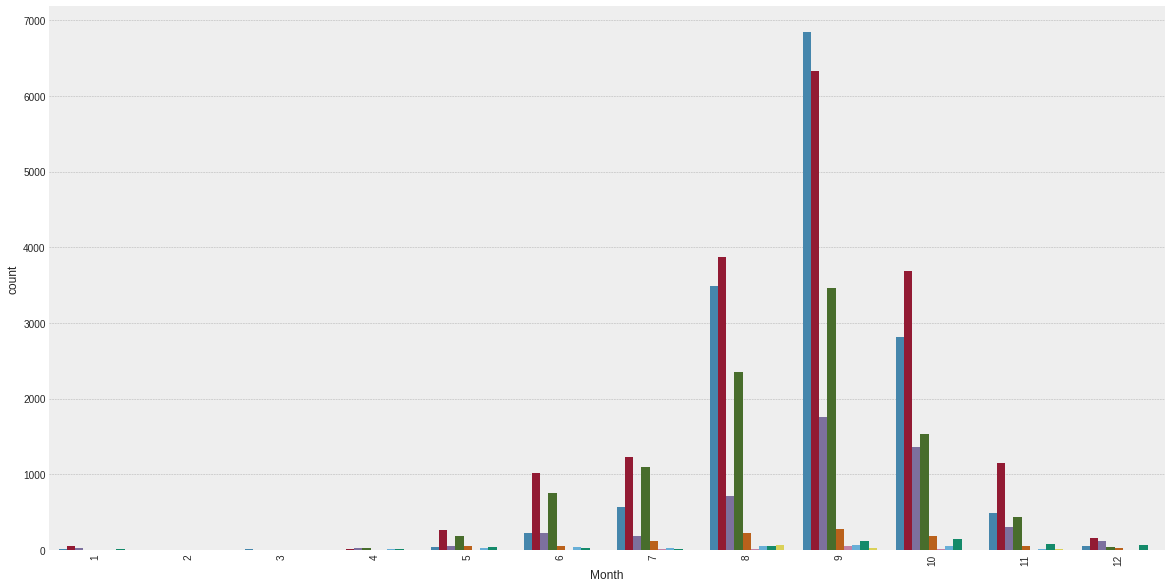

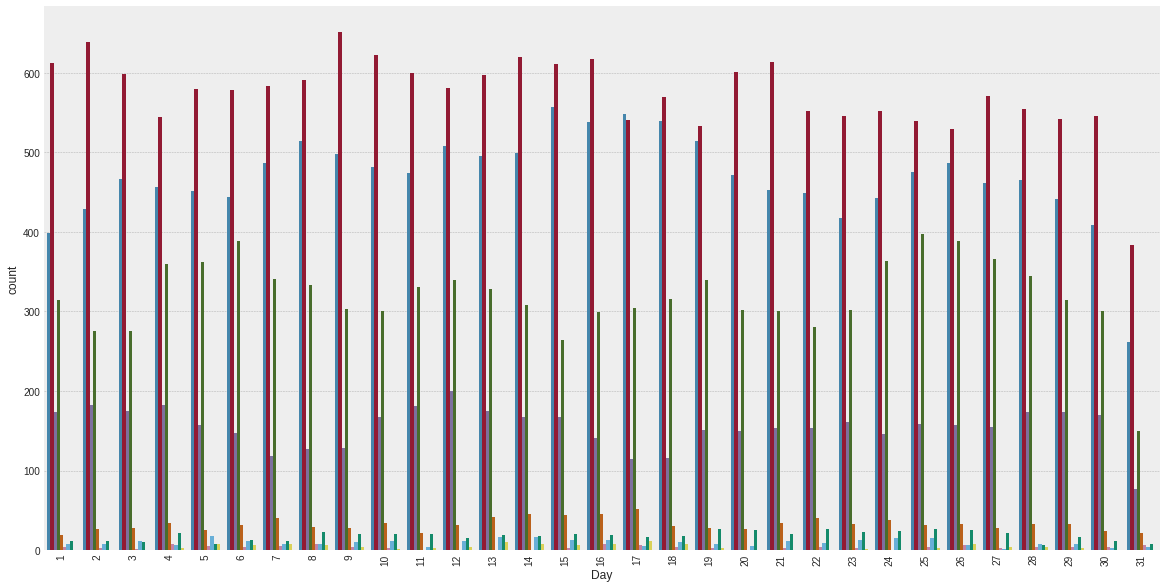

In [14]:
date = pd.to_datetime(df['Date'], format = '%Y%m%d')
df['Year'] = pd.DatetimeIndex(date).year
df['Month'] = pd.DatetimeIndex(date).month
df['Day'] = pd.DatetimeIndex(date).day

cols = ['Year', 'Month', 'Day']
for i, col in enumerate(cols):
    plt.figure(i)
    plt.figure(figsize=(20,10))
    sns.countplot(x=col, hue='Status', data=df)
    plt.legend('')
    plt.xticks(rotation=90)

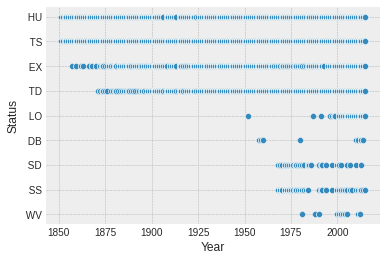

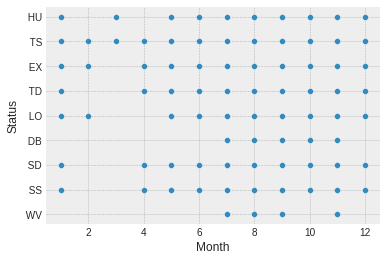

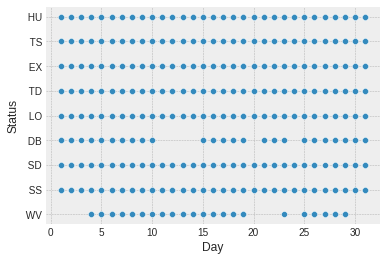

In [15]:
cols = ['Year', 'Month', 'Day']
for i, col in enumerate(cols):
    plt.figure(i)
    sns.scatterplot(df[col], df['Status'])

In [16]:
atlanticDF = df[['Latitude', 'Longitude']]
atlanticDF.head()

,Latitude,Longitude
0,28.0N,94.8W
1,28.0N,95.4W
2,28.0N,96.0W
3,28.1N,96.5W
4,28.2N,96.8W


In [17]:
#removing cardinal letters from data
atlanticDF = atlanticDF.replace({'N':''}, regex = True)
atlanticDF = atlanticDF.replace({'W':''}, regex=True)
atlanticDF = atlanticDF.replace({'E':''}, regex=True)
atlanticDF = atlanticDF.replace({'S':''}, regex=True)
atlanticDF.head

<bound method NDFrame.head of       Latitude Longitude
0         28.0      94.8
1         28.0      95.4
2         28.0      96.0
3         28.1      96.5
4         28.2      96.8
...        ...       ...
49100     41.3      50.4
49101     41.9      49.9
49102     41.5      49.2
49103     40.8      47.5
49104     40.7      45.4

[49105 rows x 2 columns]>

In [18]:
#convert time from 0hrs,600hrs,1200hrs to 00:00:00 and so on
df['Time'] = df['Time'].astype('object')
time_replace = [str(x) for x in df['Time'].unique()]
for i, txt in enumerate(time_replace):
    time_replace[i] = txt.rjust(4, '0')
    time_replace[i] = f'{time_replace[i][0:2]}:{time_replace[i][2:4]}:00'
for old, new in zip(df['Time'].unique(), time_replace):
    df.loc[df['Time'] == old, 'Time'] = new

df.head(5)

,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,Low Wind NE,Low Wind SE,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW,Year,Month,Day
0,AL011851,UNNAMED,18510625,00:00:00,,HU,28.0N,94.8W,80,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,1851,6,25
1,AL011851,UNNAMED,18510625,06:00:00,,HU,28.0N,95.4W,80,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,1851,6,25
2,AL011851,UNNAMED,18510625,12:00:00,,HU,28.0N,96.0W,80,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,1851,6,25
3,AL011851,UNNAMED,18510625,18:00:00,,HU,28.1N,96.5W,80,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,1851,6,25
4,AL011851,UNNAMED,18510625,21:00:00,L,HU,28.2N,96.8W,80,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,1851,6,25


In [19]:
#convert date like 18510625 to 1851-06-25
df['Date'] = df['Date'].astype('object')
for i, date_str in enumerate(df['Date'].unique()):
    df.loc[df['Date'] == date_str, 'Date'] = f'{str(date_str)[0:4]} - {str(date_str)[4:6]} - {str(date_str)[6:]}'

df.head(5)

,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,Low Wind NE,Low Wind SE,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW,Year,Month,Day
0,AL011851,UNNAMED,1851 - 06 - 25,00:00:00,,HU,28.0N,94.8W,80,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,1851,6,25
1,AL011851,UNNAMED,1851 - 06 - 25,06:00:00,,HU,28.0N,95.4W,80,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,1851,6,25
2,AL011851,UNNAMED,1851 - 06 - 25,12:00:00,,HU,28.0N,96.0W,80,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,1851,6,25
3,AL011851,UNNAMED,1851 - 06 - 25,18:00:00,,HU,28.1N,96.5W,80,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,1851,6,25
4,AL011851,UNNAMED,1851 - 06 - 25,21:00:00,L,HU,28.2N,96.8W,80,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,1851,6,25


In [20]:
#add date and time together and drop the date and time columns
df['Datetime'] = df['Date']+' '+df['Time']
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.drop(columns=['Date', 'Time'], inplace=True)
df.sort_values(by=['Datetime'], inplace=True)

df.head(3)

,ID,Name,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,Low Wind NE,Low Wind SE,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW,Year,Month,Day,Datetime
0,AL011851,UNNAMED,,HU,28.0N,94.8W,80,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,1851,6,25,1851-06-25 00:00:00
1,AL011851,UNNAMED,,HU,28.0N,95.4W,80,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,1851,6,25,1851-06-25 06:00:00
2,AL011851,UNNAMED,,HU,28.0N,96.0W,80,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,1851,6,25,1851-06-25 12:00:00


In [21]:
#remove any unwanted spaces at the beginning and end of the columns Name, Status and Event
df['Name'] = df['Name'].str.strip()
df['Status'] = df['Status'].str.strip()
df['Event'] = df['Event'].str.strip()

df.head(5)

,ID,Name,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,Low Wind NE,Low Wind SE,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW,Year,Month,Day,Datetime
0,AL011851,UNNAMED,,HU,28.0N,94.8W,80,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,1851,6,25,1851-06-25 00:00:00
1,AL011851,UNNAMED,,HU,28.0N,95.4W,80,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,1851,6,25,1851-06-25 06:00:00
2,AL011851,UNNAMED,,HU,28.0N,96.0W,80,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,1851,6,25,1851-06-25 12:00:00
3,AL011851,UNNAMED,,HU,28.1N,96.5W,80,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,1851,6,25,1851-06-25 18:00:00
4,AL011851,UNNAMED,L,HU,28.2N,96.8W,80,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,1851,6,25,1851-06-25 21:00:00


In [22]:
#use double quotes instead of single
print(f"Dataset contains data of {df['ID'].unique().shape[0]} individual storms from {df['Datetime'].dt.year.min()} to {df['Datetime'].dt.year.max()}.")

Dataset contains data of 1814 individual storms from 1851 to 2015.


In [23]:
#set West and South as negative numbers, North and East as positive numbers
def coordinate_mapping(x):
    coord = float(x[:-1])
    if x[-1] == 'W':
        coord *= -1
    if x[-1] == 'S':
        coord *= -1
    return coord

df['Latitude'] = df['Latitude'].apply(coordinate_mapping)
df['Longitude'] = df['Longitude'].apply(coordinate_mapping)

df.head(3)

,ID,Name,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,Low Wind NE,Low Wind SE,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW,Year,Month,Day,Datetime
0,AL011851,UNNAMED,,HU,28.0,-94.8,80,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,1851,6,25,1851-06-25 00:00:00
1,AL011851,UNNAMED,,HU,28.0,-95.4,80,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,1851,6,25,1851-06-25 06:00:00
2,AL011851,UNNAMED,,HU,28.0,-96.0,80,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,1851,6,25,1851-06-25 12:00:00


In [24]:
#find the minimum and maximum latitude/longitude
print('Min. Long.:', df.Longitude.min(), 'Max. Long', df.Longitude.max(), 'Min. Lat.:', df.Latitude.min(), 'Max. Lat.:', df.Latitude.max)

Min. Long.: -359.1 Max. Long 63.0 Min. Lat.: 7.2 Max. Lat.: <bound method Series.max of 0        28.0
1        28.0
2        28.0
3        28.1
4        28.2
         ... 
49100    41.3
49101    41.9
49102    41.5
49103    40.8
49104    40.7
Name: Latitude, Length: 49105, dtype: float64>


A minimum longitude of -359.1 makes no sense as the scale is between 180 and -180, so we have to rotate these values.

In [25]:
df.loc[df.Longitude < -180, 'Longitude'] = df.Longitude + 360
print('Min. Long.:', df.Longitude.min(), 'Max. Long', df.Longitude.max(), 'Min. Lat.:', df.Latitude.min(), 'Max. Lat.:', df.Latitude.max())

Min. Long.: -109.5 Max. Long 63.0 Min. Lat.: 7.2 Max. Lat.: 81.0


In [26]:
gdf = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df.Longitude, df.Latitude), crs = {'init' : 'epsg:4326'})
gdf.crs

<Geographic 2D CRS: +init=epsg:4326 +type=crs>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [27]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

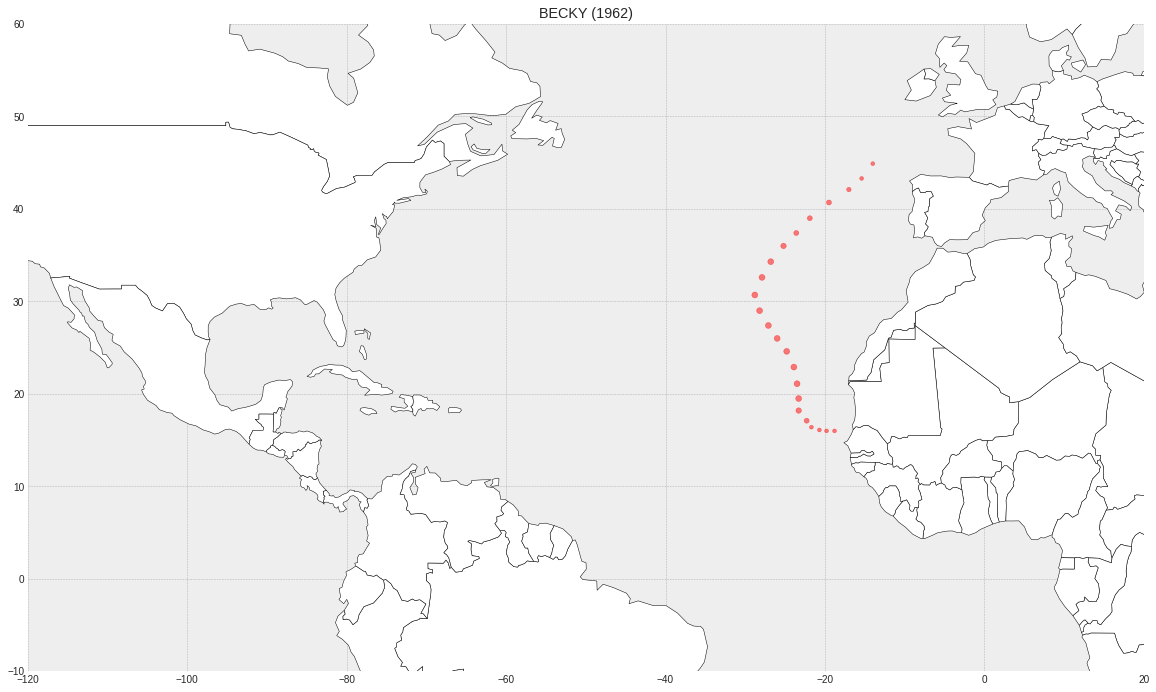

In [28]:
#print the track of any cyclone using its id
ax = world.plot(color='white', edgecolor='black', figsize=(20,15))
_ = gdf[gdf['ID'] == 'AL021962'].plot(ax=ax, c='r', markersize='Maximum Wind', alpha=0.5)
_ = plt.xlim(-120, 20)
_ = plt.ylim(-10, 60)
_ = plt.title(f'{gdf[gdf["ID"]=="AL021962"].Name.unique()[0]} ({gdf[gdf["ID"]=="AL021962"].Datetime.dt.year.unique()[0]})')

To make predictions we will construct a simplified coordinate system where the latitude is the x axis and longitude is the y axis and the positions of all storms are between 0 and 1.

In [29]:
lat_min = gdf.Latitude.min()
long_min = gdf.Longitude.min()
gdf['x'] = gdf.Latitude - lat_min
gdf['x'] = gdf['x'] / gdf['x'].max()
gdf['y'] = gdf.Longitude - long_min
gdf['y'] = gdf['y'] / gdf['y'].max()

The month and season is an important feature because this contains implicit information such as the water temperature. A continous number is much easier to work with than with months/days etc, so we will create a feature where the first of january corresponds to 0 and the 31th of december corresponds to 1.

Additionally we will create a feature "Month of year" and "Hour of day".

Each day is 1/366 of a year (with 31th of december), each hour is a 1/24 of a day and each minute 1/60 of a hour.

In [30]:
gdf['relative_time'] = ((gdf.Datetime.dt.dayofyear + (gdf.Datetime.dt.hour)/24. + (gdf.Datetime.dt.minute/60.*24))/366.)

In [31]:
gdf['month'] = gdf.Datetime.dt.month
gdf['hour'] = gdf.Datetime.dt.hour

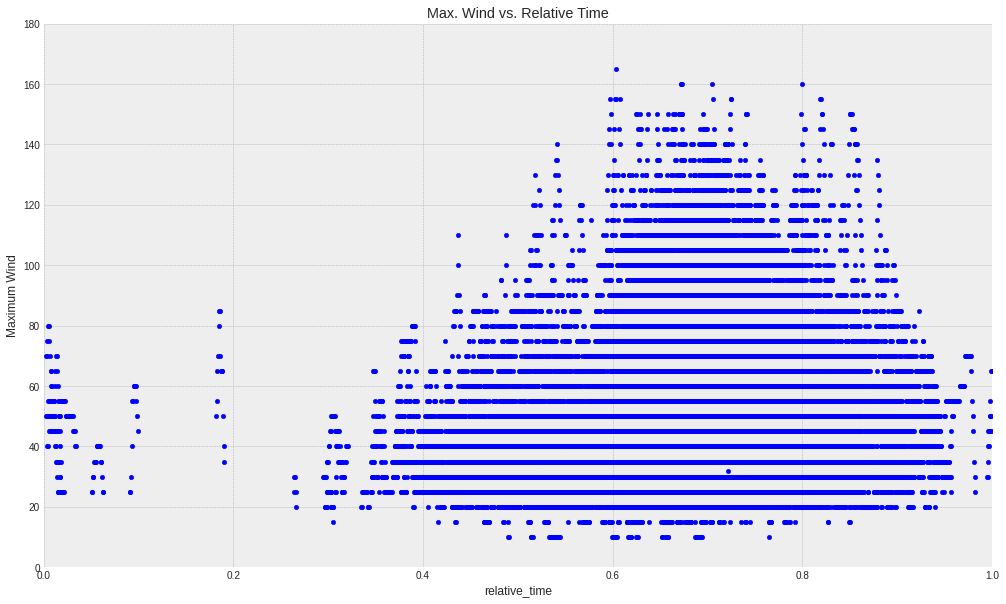

In [32]:
_ = gdf.plot(x = 'relative_time', y = 'Maximum Wind', kind = 'scatter', figsize = (17,10), title = 'Max. Wind vs. Relative Time')
_ = plt.ylim(0,180)
_ = plt.xlim(0,1)

We'll try to predict the next position in the storm trajectory. To be able to do this we need to calculate the vectors for each positional change.

In [33]:
gdf['vec_x'] = np.nan
gdf['vec_y'] = np.nan
vecs = {'x': [], 'y': [], 'id': []}
for storm_id in gdf['ID'].unique():
    last_x = 0
    last_y = 0
    for i, row in gdf[gdf['ID'] == storm_id].iterrows():
        if last_x == 0:
            last_x = row.x
            last_y = row.y
        else:
            vec_x = row.x - last_x
            vec_y = row.y - last_y
            vecs['x'].append(vec_x)
            vecs['y'].append(vec_y)
            vecs['id'].append(i)
            last_x = row.x
            last_y = row.y
gdf.loc[vecs['id'], 'vec_x'] = vecs['x']
gdf.loc[vecs['id'], 'vec_y'] = vecs['y']

Because we can only predict one value we'll need two models to predict the trajectory. As the independent prediction of the x and y position probably won't work we will use one model to predict the change in direction (angle) and another for change in distance (length).

In [34]:
gdf['vec_len'] = np.sqrt((gdf['vec_x']**2)+(gdf['vec_y']**2))

In [35]:
def calculate_direction(vec_x, vec_y):
    def vec_angle(a, b):
        return np.arccos(np.dot(a,b) / (np.linalg.norm(a)* np.linalg.norm(b)))
    ref_vec = np.array([vec_x, vec_y])
    N_vec = np.array([0,1])
    S_vec = np.array([0,-1])
    E_vec = np.array([1,0])
    W_vec = np.array([-1,0])
    N_angle = vec_angle(ref_vec, N_vec)
    E_angle = vec_angle(ref_vec, E_vec)
    W_angle = vec_angle(ref_vec, W_vec)
    return_angle = N_angle
    if W_angle < E_angle:
        return_angle = 2*np.pi - return_angle
    return return_angle

In [36]:
gdf['vec_direction'] = gdf.apply(lambda x: calculate_direction(x.vec_x, x.vec_y), axis = 1)

gdf['tdelta'] = np.nan
tdeltas = {'t': [], 'id': []}
for storm_id in gdf['ID'].unique():
    last_time = 0
    for i, row in gdf[gdf['ID'] == storm_id].iterrows():
        if last_time == 0:
            last_time = row.Datetime
        else:
            tdeltas['t'].append((row.Datetime - last_time).seconds)
            tdeltas['id'].append(i)
            last_time = row.Datetime
gdf.loc[tdeltas['id'], 'tdelta'] = tdeltas['t']

gdf = gdf[gdf['tdelta'] == 21600]
gdf.shape

(45717, 35)

In [37]:
gdf['prev_len'] = np.nan
gdf['prev_direction'] = np.nan
prevs = {'len': [], 'direction': [], 'id': []}
for storm_id in gdf['ID'].unique():
    last_len = False
    last_direction = False
    for i, row in gdf[gdf['ID'] == storm_id].iterrows():
        if last_len == False:
            last_len = row.vec_direction
        else:
            prevs['len'].append(last_len)
            prevs['direction'].append(last_direction)
            prevs['id'].append(i)
            last_len = row.vec_len
            last_direction = row.vec_direction
gdf.loc[prevs['id'], 'prev_len'] = prevs['len']
gdf.loc[prevs['id'], 'prev_direction'] = prevs['direction']

gdf.dropna(how='any', inplace = True)
gdf.shape

(43683, 37)

The hypothesis for both models (distance traveled, direction) depends on the following features:

1. Maximum Wind: The highest measured windspeed
2. Position (x, y): Probably the most important feature, as storms behave similary in the gulf etc. (my hope is, that the models create some kind of artifical grid, e.g. if x>0.1 and x < 0.2 etc., even though that requires a lot of splits)
3. Month of year: A latent variable for the genereal climatic conditions (Temperature, Jet stream etc.)
4. Hour of day: A latent variable for temperature (usually the temperature at 12am is different than at 2am etc.)
5. Previous distance/direction

In [38]:
gdf_prediction_direction = gdf[['Maximum Wind', 'x', 'y', 'month', 'hour', 'prev_len', 'prev_direction', 'vec_direction']]
gdf_prediction_length = gdf[['Maximum Wind', 'x', 'y', 'month', 'hour', 'prev_len', 'prev_direction', 'vec_len']]
X_direction = gdf_prediction_direction.values[:,:-1]
y_direction = gdf_prediction_direction.values[:,-1]
X_length = gdf_prediction_length.values[:,:-1]
y_length = gdf_prediction_length.values[:,-1]

In [39]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
X_direction_train, X_direction_test, y_direction_train, y_direction_test = train_test_split(X_direction, y_direction, test_size = 0.2, random_state = 42)
X_length_train, X_length_test, y_length_train, y_length_test = train_test_split(X_length, y_length, test_size = 0.2, random_state = 42)

In [40]:
model_direction = GradientBoostingRegressor(n_estimators = 100, learning_rate = 0.1, max_depth = 5, random_state =0, loss = 'ls').fit(X_direction_train, y_direction_train)
mean_squared_error(y_direction_test, model_direction.predict(X_direction_test))

0.37171190331386467

In [41]:
model_length = GradientBoostingRegressor(n_estimators = 100, learning_rate = 0.1, max_depth = 5, random_state = 0, loss = 'ls').fit(X_length_train, y_length_train)
mean_squared_error(y_length_test, model_length.predict(X_length_test))

1.4598824379865422e-05

In [42]:
#import only this version of shap as others are not supported on google colab
!pip install shap==0.39.0

     |████████████████████████████████| 356 kB 8.4 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491641 sha256=7e707810e917d76682a5305e837af0a4775e076b37bd503726f5da1e55bb7831
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap


In [43]:
import shap

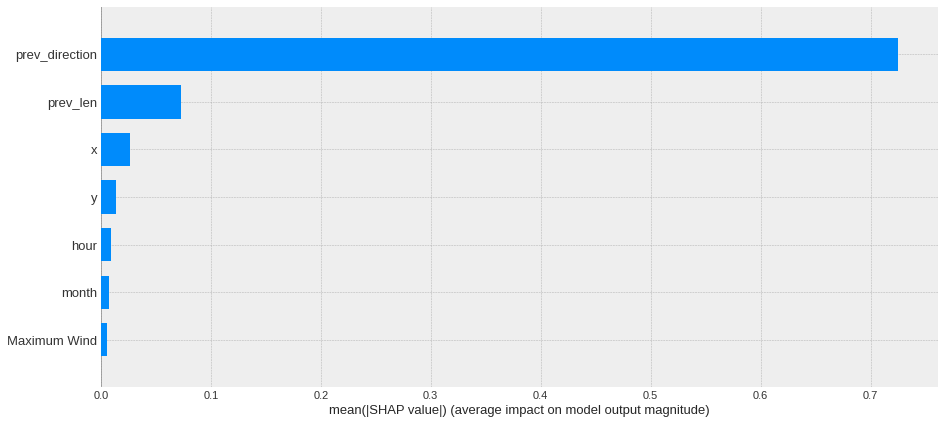

In [44]:
#Let's look at the feature importances
explainer_direction = shap.TreeExplainer(model_direction)
shap_values_direction = explainer_direction.shap_values(X_direction_test)
shap.summary_plot(shap_values_direction, X_direction_test, plot_type = 'bar', feature_names = ['Maximum Wind', 'x', 'y', 'month', 'hour', 'prev_len', 'prev_direction'], title='Feature importances model_direction', plot_size = (15,7))

As expected the previous direction has a huge influence, followed by the latitude and the previous distance.

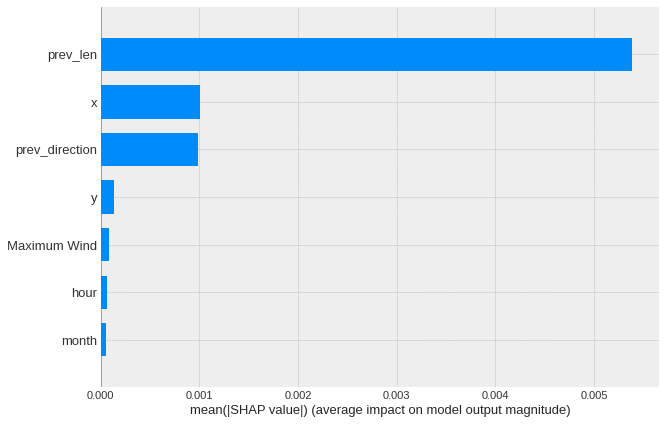

In [45]:
explainer_length = shap.TreeExplainer(model_length)
shap_values_length = explainer_length.shap_values(X_length_test)
shap.summary_plot(shap_values_length, X_length_test, plot_type="bar", feature_names=["Maximum Wind", "x", "y", "month", "hour", "prev_len", "prev_direction"], title="Feature importances model_length", plot_size=(10,7))

For the distance/length prediction the previous value is the most important one.

In [46]:
lat_min = df.Latitude.min()
long_min = df.Longitude.min()
temp_x = df.Latitude - lat_min
temp_y = df.Longitude - long_min
x_max = temp_x.max()
y_max = temp_y.max()

def coords_to_latlong(x, y, lat_min, long_min, x_max, y_max):
    return (x*x_max)+lat_min, (y*y_max)+long_min

In [47]:
gdf[gdf.Name=="BECKY"].ID.unique()

array(['AL021958', 'AL021962', 'AL021966', 'AL021970', 'AL091974'],
      dtype=object)

In [48]:
storm_id = "AL021962"
gdf_pred = gdf[["Latitude", "Longitude", "Maximum Wind", "x", "y", "month", "hour", "prev_len", "prev_direction", "vec_len", "vec_direction"]][gdf.ID==storm_id]
X_pred_direction = gdf_pred[["Maximum Wind", "x", "y", "month", "hour", "prev_len", "prev_direction"]].iloc[1:].values
X_pred_len = gdf_pred[["Maximum Wind", "x", "y", "month", "hour", "prev_len", "prev_direction"]].iloc[1:].values

In [49]:
df_pred = pd.DataFrame({"pred_len": model_length.predict(X_pred_len), "pred_direction": model_direction.predict(X_pred_direction)})

In [50]:
df_pred["pred_x"] = np.nan
df_pred["pred_y"] = np.nan
df_pred["real_x"] = gdf_pred["x"].iloc[1:].values
df_pred["real_y"] = gdf_pred["y"].iloc[1:].values

In [51]:
last_x = gdf_pred["x"].iloc[0]
last_y = gdf_pred["y"].iloc[0]
coords = {"x": [], "y": [], "id": []}
for i, row in df_pred.iterrows():
    vector = np.array([0,1])
    R = np.array([[np.cos(row.pred_direction), -np.sin(row.pred_direction)], [np.sin(row.pred_direction), np.cos(row.pred_direction)]])
    vector = np.matmul(vector, R)
    vector = vector/np.linalg.norm(vector)
    vector *= row.pred_len
    coords["x"].append(last_x+vector[0])
    coords["y"].append(last_y+vector[1])
    coords["id"].append(i)
    last_x = row.real_x
    last_y = row.real_y
df_pred.loc[coords["id"], "pred_x"] = coords["x"]
df_pred.loc[coords["id"], "pred_y"] = coords["y"]

In [52]:
df_pred["pred_Longitude"] = np.nan
df_pred["real_Longitude"] = np.nan
df_pred["pred_Latitude"] = np.nan
df_pred["real_Latitude"] = np.nan
latslongs = {"pred_Longitude": [], "real_Longitude": [], "pred_Latitude": [], "real_Latitude": [], "id": []}
for i, row in df_pred.iterrows():
    real_Latitude, real_Longitude = coords_to_latlong(row.real_x, row.real_y, lat_min, long_min, x_max, y_max)
    latslongs["real_Latitude"].append(real_Latitude)
    latslongs["real_Longitude"].append(real_Longitude)
    pred_Latitude, pred_Longitude = coords_to_latlong(row.pred_x, row.pred_y, lat_min, long_min, x_max, y_max)
    latslongs["pred_Latitude"].append(pred_Latitude)
    latslongs["pred_Longitude"].append(pred_Longitude)
    latslongs["id"].append(i)
df_pred.loc[latslongs["id"], "real_Latitude"] = latslongs["real_Latitude"]
df_pred.loc[latslongs["id"], "real_Longitude"] = latslongs["real_Longitude"]
df_pred.loc[latslongs["id"], "pred_Latitude"] = latslongs["pred_Latitude"]
df_pred.loc[latslongs["id"], "pred_Longitude"] = latslongs["pred_Longitude"]

In [53]:
df_pred

,pred_len,pred_direction,pred_x,pred_y,real_x,real_y,pred_Longitude,real_Longitude,pred_Latitude,real_Latitude
0,0.005727,2.820769,0.122402,0.509347,0.124661,0.508986,-21.637581,-21.7,16.233294,16.4
1,0.007421,2.514447,0.129016,0.502977,0.134146,0.505507,-22.736488,-22.3,16.721381,17.1
2,0.010248,1.973195,0.143576,0.501494,0.149051,0.499710,-22.992317,-23.3,17.795899,18.2
3,0.015609,1.948651,0.163560,0.493951,0.166667,0.499710,-24.293376,-23.3,19.270706,19.5
4,0.016351,1.603672,0.183009,0.499173,0.188347,0.498551,-23.392714,-23.5,20.706083,21.1
5,0.020187,1.618422,0.208511,0.497590,0.212737,0.496232,-23.665780,-23.9,22.588100,22.9
6,0.021960,1.635501,0.234651,0.494812,0.235772,0.491014,-24.144941,-24.8,24.517280,24.6
7,0.021901,1.779902,0.257197,0.486468,0.254743,0.484058,-25.584257,-26.0,26.181121,26.0
8,0.018999,1.944097,0.272433,0.477129,0.273713,0.477681,-27.195225,-27.1,27.305577,27.4
9,0.018779,1.896120,0.291506,0.471679,0.295393,0.471304,-28.135340,-28.2,28.713178,29.0


In [54]:
gdf_real = gpd.GeoDataFrame(df_pred,geometry=gpd.points_from_xy(df_pred.real_Longitude,df_pred.real_Latitude), crs={'init' :'epsg:4326'})
gdf_pred = gpd.GeoDataFrame(df_pred,geometry=gpd.points_from_xy(df_pred.pred_Longitude,df_pred.pred_Latitude), crs={'init' :'epsg:4326'})

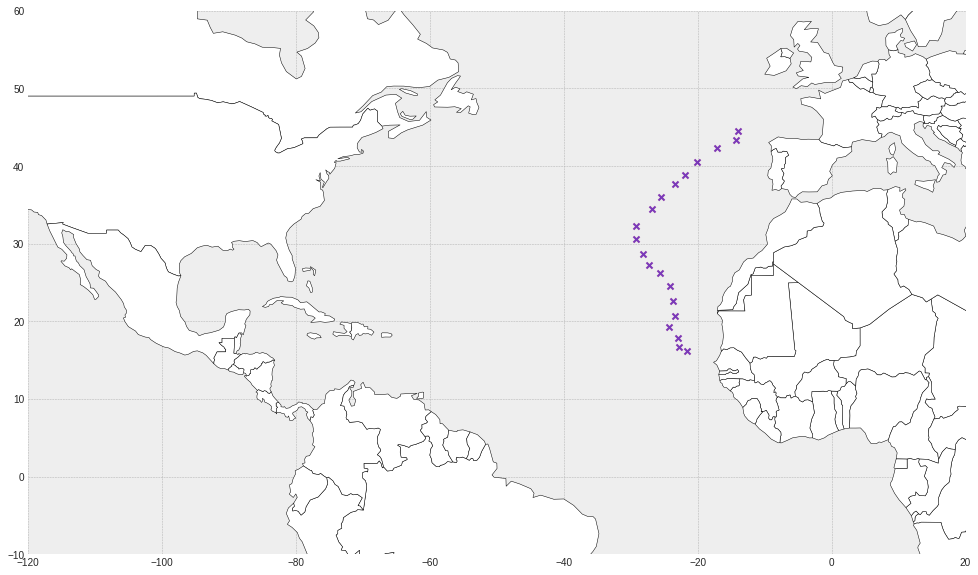

In [55]:
ax = world.plot(color="white", edgecolor="black", figsize=(20,10))
_ = gdf_real.plot(ax=ax, c="r", marker="x", alpha=0.5)
_ = gdf_pred.plot(ax=ax, c="b", marker="x", alpha=0.5)
_ = plt.xlim(-120, 20)
_ = plt.ylim(-10, 60)